# Postprocessing of simulation data from Kinetiscope
This jupyter notebook demonstrates how to use the StackSim.py module to extract simulation data from XML files generated by the kinetic Monte Carlo simulator [Kinetiscope](http://www.kinetiscope.com). These simulations use a set of chemical and diffusion equations to simulate the oxidation of organic aerosol initiated at the surface. The simulations are set up as a stack of thin rectangular prisms that represent spherical shells in an organic aerosol particle. Because of this change in geometry, the data from the simulations has to be postprocessed so that the outer rectangular prisms are weighted more than the inner rectangular prisms. Here, the height of each prism is taken as the thickness of the spherical shell. 

Note: If you do not wish to see the code and just care about the results, feel free to press the "Hide Code" button below to hide the code used to postprocess and plot the data.

In [2]:
%%HTML 
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>

In [1]:
# Import modules needed for postprocessing and unzip and load data

# Contains classes for compartments and simulations
import StackSim


import warnings
warnings.filterwarnings('ignore')
import os
import requests
import zipfile
import errno
import numpy as np
import pandas as pd
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re
import xlsxwriter

# Create subdirectory for data if it does not exist

subdir = os.path.join(os.path.curdir, "simdata")

if not os.path.isdir(subdir):
    os.mkdir(subdir)
 

# Unzip XML files (.zip file comes with github repository)

with zipfile.ZipFile("model_scenarios_xml.zip", "r") as zip_ref:
    zip_ref.extractall(subdir)
    
# Create scenario-file dictionary

ScenarioFiles = {'Scenario 1' : 'tri_109nm_sc1.xml', 
                 'Scenario 1 145nm' : 'tri_145nm_sc1.xml',
                 'Scenario 1A' : 'tri_109nm_sc1a.xml', 
                 'Scenario 1A 145nm' : 'tri_145nm_sc1a.xml',
                 'Scenario 2' : 'tri_109nm_sc2.xml', 
                 'Scenario 2 145nm' : 'tri_145nm_sc2.xml',
                 'Scenario 2A' : 'tri_109nm_sc2a.xml',
                 'Scenario 2A 145nm' : 'tri_145nm_sc2a.xml'}

# Create empty scenario dictionary

Scenarios = dict()

## Weighting of functional groups and carbon backbones
After the loading the data, the species amounts are weighted by their relative contributions to different elements and mass. In the simulation, a molecule is represented as a collection of oxygen and hydrogen functional groups and carbon number backbones. For example, a secondary alcohol group (OHCH_sec) counts once for oxygen and twice for hydrogen, and a 18-carbon fatty acid counts for 18 carbon atoms. These weights are used to find the average elemental composition and mass of the organic aerosol.

In [2]:
# Generate lists for finding weighting aggregate species from individual
# functional group or carbon backbone species

carbon_min, carbon_max = 1, 30

missing_carbon_no = [1, 30]

# Create carbon-30 lumped species from each component

carbon_no_dict = {"nC30" : [["C30", 1], ["C30_COOH", 1], ["C30_COOH_O", 1], ["C30_HOOCCOOH", 1], ["C30_O2", 1], ["C30_O", 1]]}

# Initialize list of lists

carbon_list = [["nC30", 30]]

for i in range(carbon_min, carbon_max+1, 1):
    if i in missing_carbon_no:
        pass
    else:
        no_C = "C"+str(i)
        
        # Add entry to lumped carbon number dictionary
        carbon_no_dict["n"+no_C] = [[no_C, 1], [no_C+"_O2", 1], [no_C+"_COOH", 1], [no_C+"_COOH_O", 1], [no_C+"_HOOCCOOH", 1]]
        
        # Add entry to list of list for carbon number weighting
        carbon_list.append(["n"+no_C, i])

# Generate oxygen and hydrogen species weighting lists

oxygen_list = [["OC_sec", 1], ["OCH_prim", 1], ["OHCH2_prim", 1], ["OHCH_sec", 1],
               ["OC_alpha", 1], ["OHCH_alpha", 1], ["HO_OOC_prim", 3],
               ["HOOCH2_prim", 2], ["HOOCH_alpha", 2], ["HOOCH_sec", 2], ["HOOC_prim", 2]]

hydrogen_list = [["CH3_prim", 3], ["CH3_prim_s", 3], ["CH2_sec", 2], ["CH2_alpha", 2], 
                 ["OCH_prim", 1], ["OHCH_sec", 2], ["OHCH2_prim", 3], ["OHCH_alpha", 2],
                 ["HO_OOC_prim", 1], ["HOOCH2_prim", 3], ["HOOCH_alpha", 2], ["HOOCH_sec", 2], ["HOOC_prim", 1]]

# Generate mass weighting lists

mass_list = [["carbon", 12], ["oxygen", 16], ["hydrogen", 1]]

mass_list_r = [["carbon_r", 12], ["oxygen_r", 16], ["hydrogen_r", 1]]

## Finding aggregate species and radial correction

After initializing the weighting lists for each species, the simulation files are processed using the Simulation and Compartment classes in StackSim.py. First, the simulation results are loaded into simulation and compartment objects from the XML files. Then, aggregate species for carbon number, total carbon; oxygen; and hydrogen, and mass are created. The species ratios H/C and O/C are also calculated from these values.

Radial corrections are also calculated for each of these species and the starting material to properly weight the outer compartments. The thickness of each compartment is considered to be the same as the thickness of an equivalent spherical shell. The initial radial $r_i$ and final radial coordinates $r_f$ are then used to find the volume of a spherical shell ($V_{ \text{shell} }$) as follows:

$V_{ \text{shell} } = 4/3 \pi (r^3_f - r^3_i)$.

The ratio of the volume of the shell and the volume of the compartment ($V_{ \text{box} }$) is then used to weight the amount of any given species ($N$) by its position along the radial axis as follows:

$N_{ \text{corr} } = V_{ \text{shell} } N / V_{ \text{box} }$.

Note: the below code can take a while to run so please be patient since it is loading and processing 8 large files.

In [3]:
-

## Collecting average aerosol properties

After processing the data, the simulation data for each scenario are then collected into data frames. These data frames are used to summarize and plot several features of the simulations. 

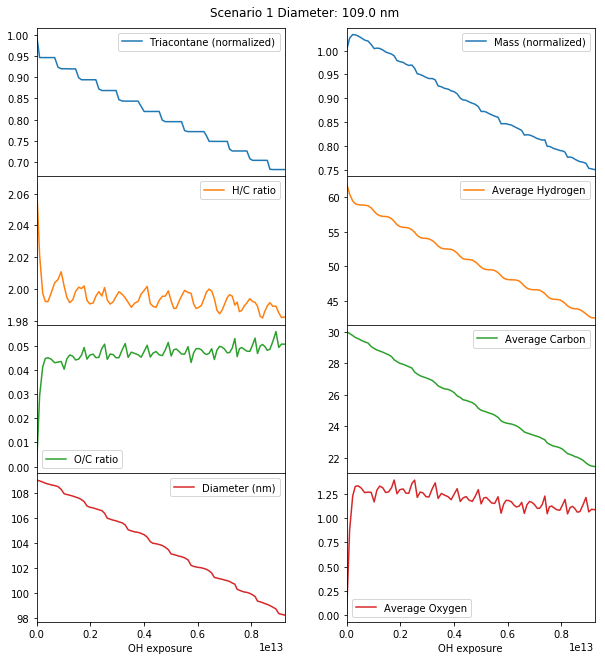

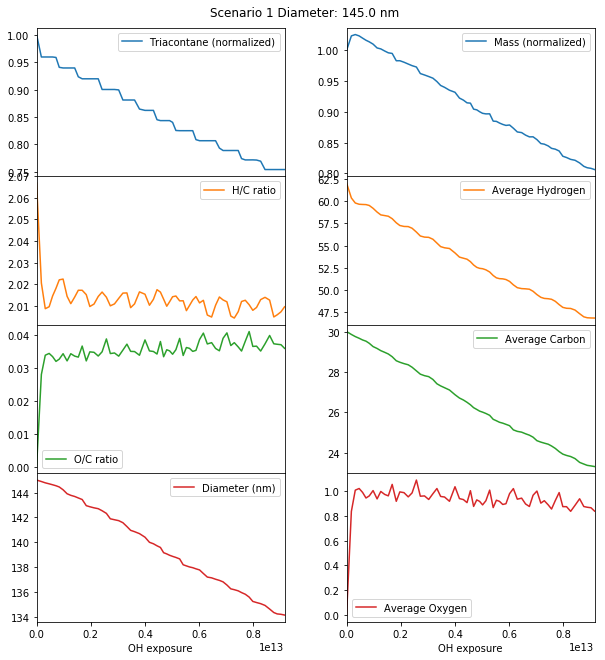

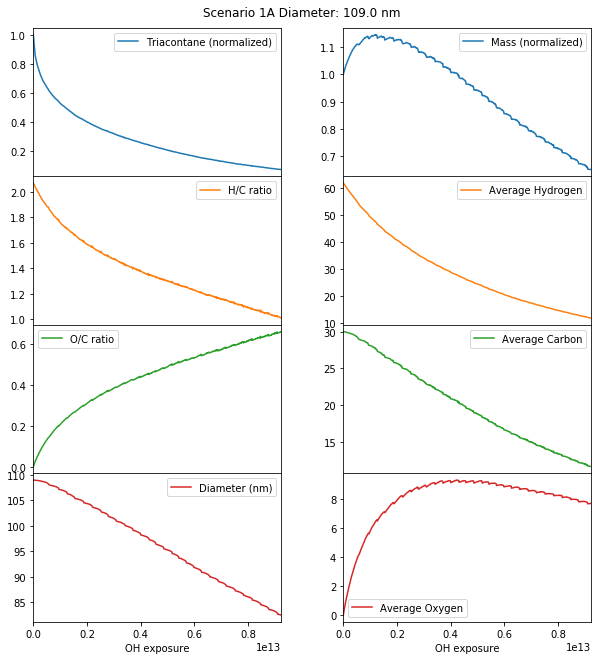

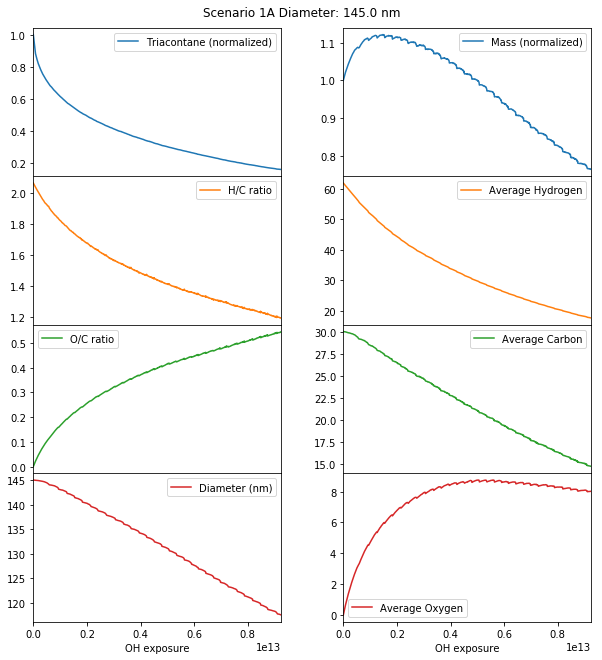

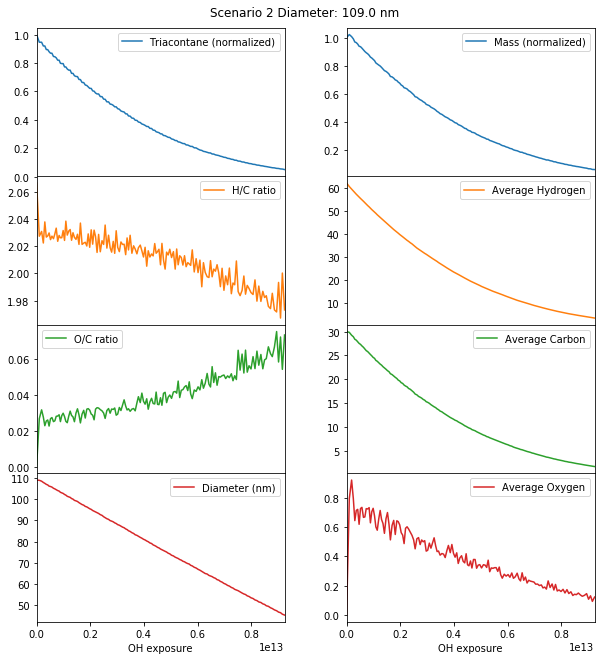

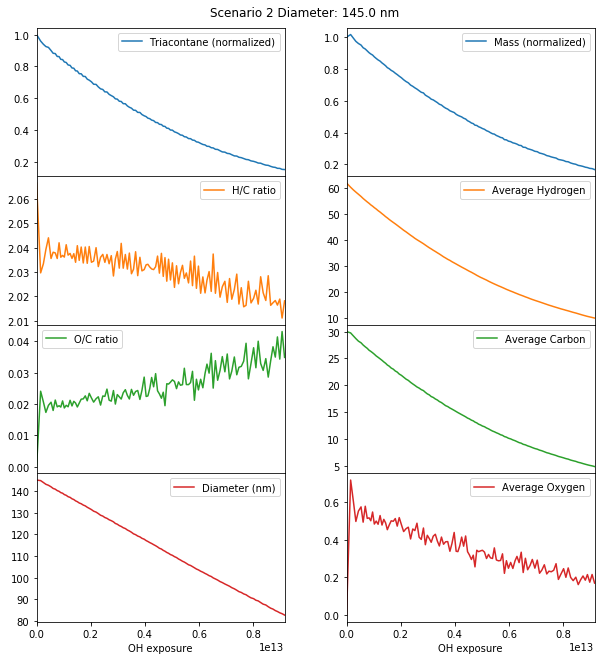

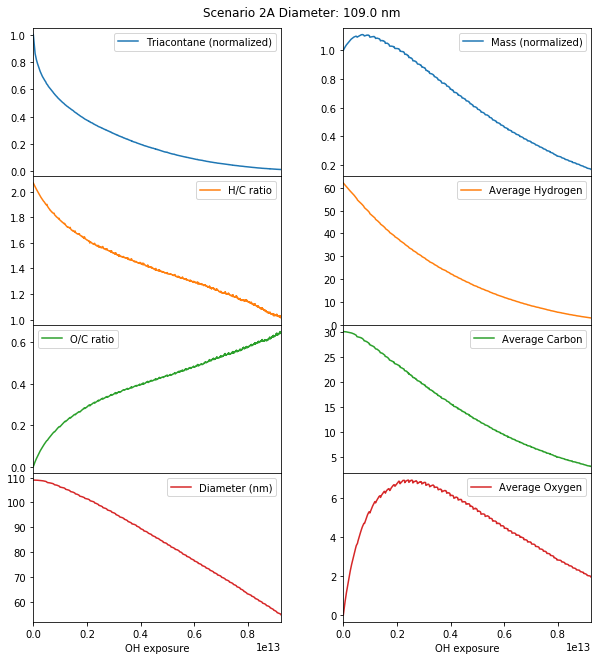

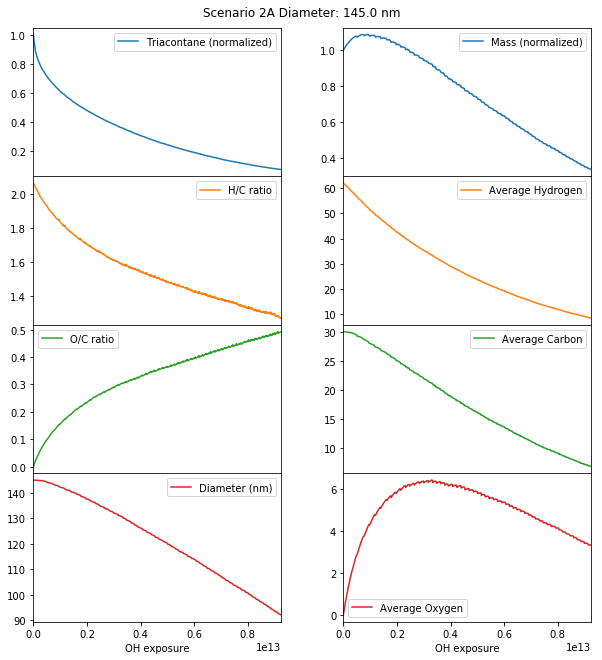

In [4]:
%matplotlib inline

# OH and concentration and units for OH exposure
OH_conc = 2.5E11
OH_exp_units = r'OH exposure (molecules cm$^{-3}$ s)'

# Create empty dictionary to hold scenario data frames and panels
ScenarioData = dict()

for scenario in ScenarioFiles.keys():
    # Create reference to current simulation to save on typing
    simulation = Scenarios[scenario]
    
    # Find OH exposure
    OH_exp = OH_conc*simulation.time
    
    # Initialize data frame with OH exposure
    SimData = pd.DataFrame({"OH exposure" : OH_exp})
        
    # Find diameter of particle
    last_cmpt = simulation.compartments[(0, simulation.num_rows-1, 0)]
    diameter = 2*(last_cmpt.positions["y"]+last_cmpt.dimensions["y"])/1E-7
    

    
    # Find initial mass and carbon amount to normalize quantities
    tri_init = simulation.species["Tri_r"][0]
    mass_init = simulation.species["mass_r"][0]
    carbon_init = simulation.species["carbon_r"][0]
    
    # Add average data to data frame
    new_data = {"Triacontane (normalized)" : simulation.species["Tri_r"]/tri_init,
                "Mass (normalized)" : simulation.species["mass_r"]/mass_init,
                "Diameter (nm)" : diameter, 
                "Average Hydrogen" : simulation.species["hydrogen_r"]/carbon_init*30, 
                "Average Carbon" : simulation.species["carbon_r"]/carbon_init*30, 
                "Average Oxygen" : simulation.species["oxygen_r"]/carbon_init*30, 
                "H/C ratio" : simulation.species["H/C ratio"], 
                "O/C ratio" : simulation.species["O/C ratio"]}

    SimData = SimData.assign(**new_data)

    # Add carbon number data to data frame
    for carbon, weight in carbon_list:
        carbondata = {carbon : simulation.species[carbon+"_r"]}
        SimData = SimData.assign(**carbondata)

    
    # Create plot of averages
    fig, axes = plt.subplots(4, 2, figsize=(10, 10), sharex=True)
    
    fig.suptitle(re.sub(" 145nm", "", scenario)+" Diameter: "+str(diameter[0])+" nm ")
    fig.subplots_adjust(top=0.95)
    
    plt.subplots_adjust(wspace=0.25, hspace=0)
    
    target1 = [axes[0, 0], axes[1, 0], axes[2, 0], axes[3, 0]]
    target2 = [axes[0, 1], axes[1, 1], axes[2, 1], axes[3, 1]]
    
    SimData.plot(ax = target1, x = "OH exposure", 
                 y = ["Triacontane (normalized)", "H/C ratio", "O/C ratio", "Diameter (nm)"],
                 subplots = True, sharex = False)
    
    SimData.plot(ax = target2, x = "OH exposure",
                 y = ["Mass (normalized)", "Average Hydrogen", "Average Carbon", "Average Oxygen"],
                 subplots = True, sharex = False)
    
    ScenarioData[scenario+" averages"] = SimData

## Generating aerosol contour maps

After collecting the average data, contour maps of triacontane, peroxy radicals, and the O/C ratio are generated for each simulation. The aerosol compartment content is interpolated onto a 0.1 nm resolution grid (from a compartment size of 0.5 nm). These are put into a data panel for each species.

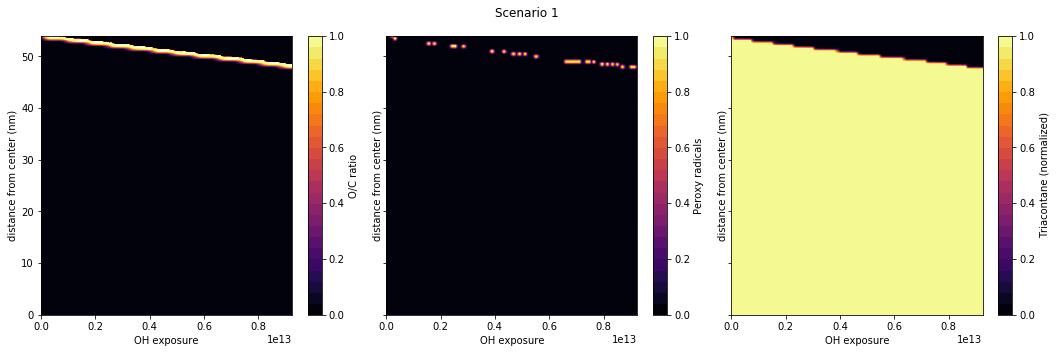

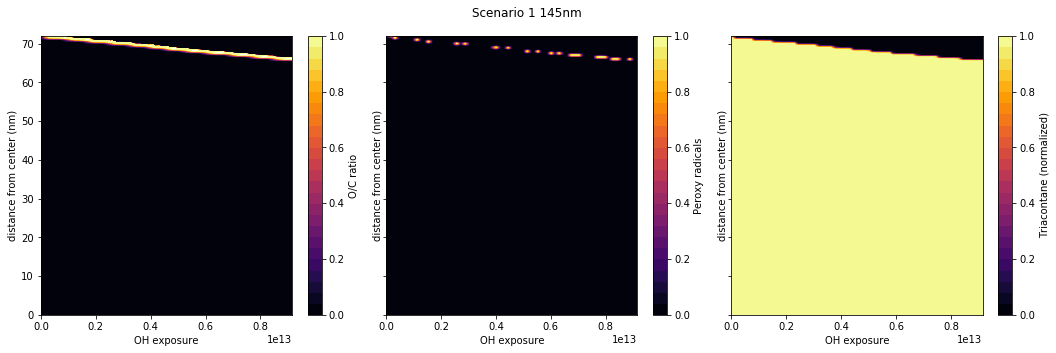

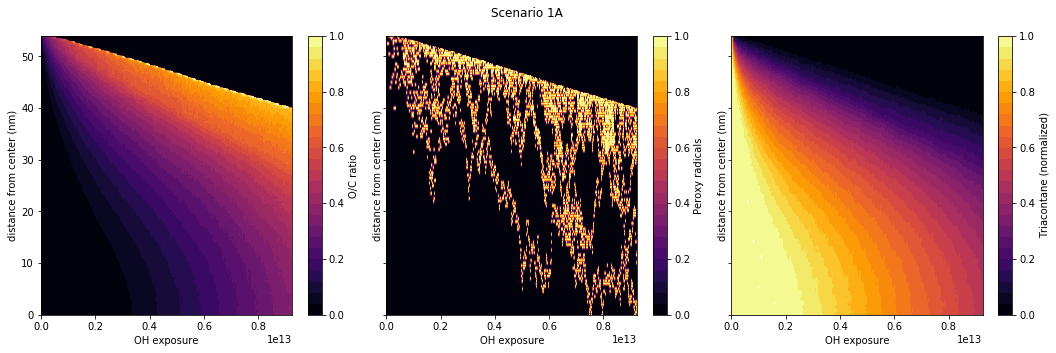

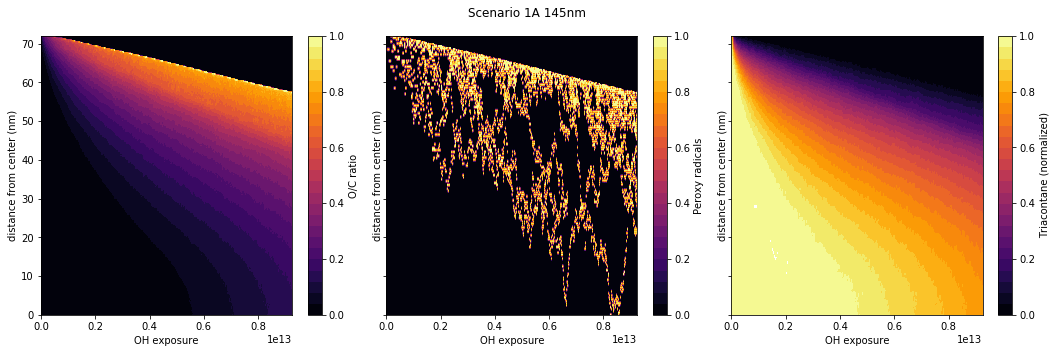

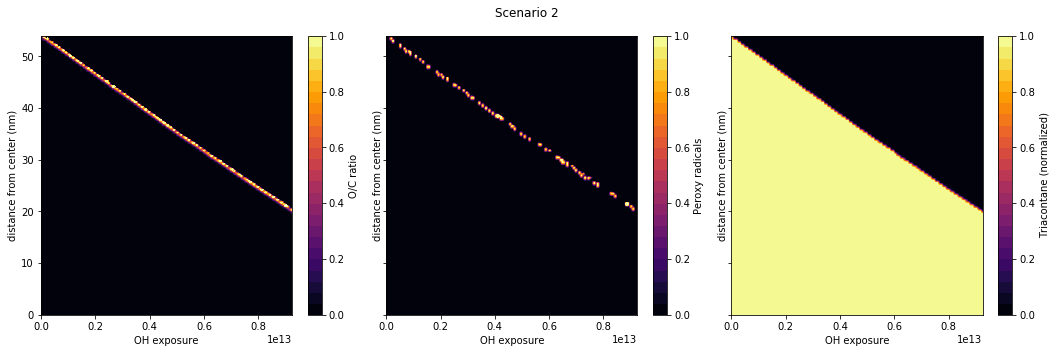

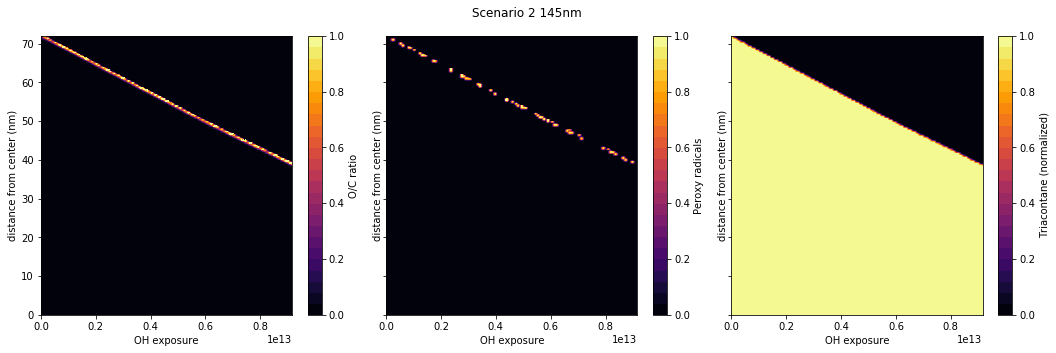

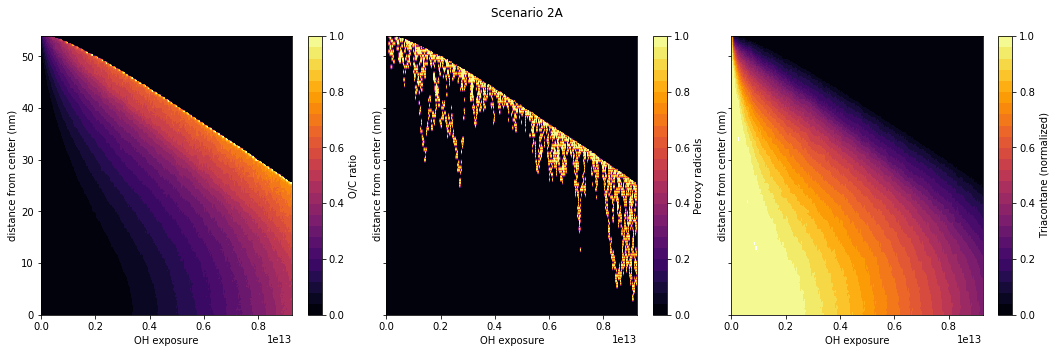

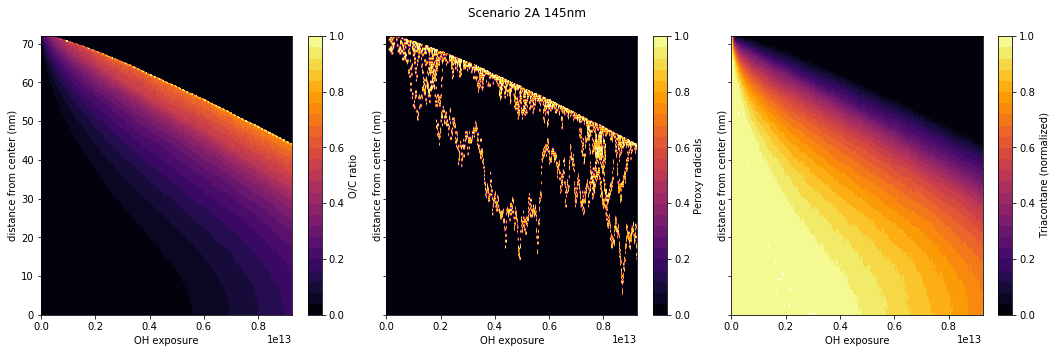

In [5]:
%matplotlib inline
for scenario in ScenarioFiles.keys():
        
    # create reference to save on typing
    simulation = Scenarios[scenario]
    
    # Find OH exposure for simulation
    OH_exp = OH_conc*simulation.time
    
    # Calculate contour maps for each species
    simulation.calcContourInterpolated("Tri", reverse_axis = True)
    simulation.calcContourInterpolated("OO_sec", reverse_axis = True)
    simulation.calcContourInterpolated("O/C ratio", reverse_axis = True)
    
    # Place data into panel
    
    contour_data = {"Triacontane (normalized)": 
                    simulation.species_contour["Tri"]/simulation.species_contour["Tri"][0,0],
                   "Peroxy radicals": simulation.species_contour["OO_sec"],
                   "O/C ratio": simulation.species_contour["O/C ratio"]}
    
    ScenarioData[scenario+" contours"] = pd.Panel(contour_data, 
                                                  major_axis = simulation.position_int,
                                                 minor_axis = OH_exp)
    
    # Generate plots of contour maps
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey = True)
    
    plt.subplots_adjust(wspace=0.1, hspace=1.75)
    
    fig.suptitle(scenario)
    fig.subplots_adjust(top=0.9)
    
    i = 0
    for species, data in ScenarioData[scenario+" contours"].iteritems():
        
        # Find maximum value on contour and generate contour levels and labels
        #maximum = data.values.max()
        levels = np.linspace(0, 1, num=26)
        labels = np.linspace(0, 1, num=6)
        
        # Create contour map from data frame
        cm = axes[i].contourf(data.columns.values, data.index/1E-7, data, 
                           levels = levels, cmap='inferno')
        
        # Add axis labels
        axes[i].set_xlabel("OH exposure")
        axes[i].set_ylabel("distance from center (nm)")
        
        # Add color bar
        cb = fig.colorbar(cm, ax=axes[i], ticks=labels)
        cb.set_label(species)
        
        i += 1
        
        
    

## Export to Excel

Finally, the data are saved into an Excel workbook for each scenario. (Note: can take a long time for large simulation files)

In [23]:
for scenario in ScenarioFiles.keys():
    # Create an excel writer
    writer = pd.ExcelWriter(scenario+'.xlsx', engine='xlsxwriter')
    workbook = writer.book
    
    # Add a sheet that summarizes the model
    summary = workbook.add_worksheet("model summary")
    
    summary.write('A1', scenario)
    
    # Create reference to simulation
    simulation = Scenarios[scenario]
    
    # Get simulation filename and strip out directory information
    sim_filename = simulation.data_dom.getElementsByTagName("file")[0].firstChild.nodeValue
    sim_filename = os.path.basename(sim_filename)
    
    summary.write('B1', sim_filename)
    summary.write('A2', 'XML file')
    summary.write('B2', ScenarioFiles[scenario])
    summary.write('A3', 'Compartment dimensions (cm)')
    
    # Create reference to a compartment
    comp = simulation.compartments[(0,0,0)]
    
    dimensions = str(comp.dimensions["x"][0]) + " x " + \
                 str(comp.dimensions["y"][0]) + " x " + \
                 str(comp.dimensions["z"][0])
    
    summary.write('B3', dimensions)
    summary.write('A4', 'OH concentration (molecules cm-3)')
    summary.write('B4', OH_conc)
    summary.write('A5', 'Diffusion coefficient (cm2 s-1)')
    summary.write('B5', 8.39E-19)
    summary.write('A6', 'Plasticization diffusion coefficient (cm2 s-1)')
    if re.search("[12]A", scenario):
        summary.write('B6', 3E-13)
    else:
        summary.write('B6', 'None')
    summary.write('A7', 'OH + COOH rate coefficient (cm3 molecule-1 s-1)')
    if "2" in scenario:
        summary.write('B7', 5.4E-13)
    else:
        summary.write('B7', 1E-14)
    
    # Write average and contour data to separate sheets
    ScenarioData[scenario+" averages"].to_excel(writer, sheet_name='average data')
    for species, data in ScenarioData[scenario+" contours"].iteritems():
        sheet_name = re.sub("/", " to ", species)
        data.to_excel(writer, sheet_name=re.sub("/", " to ", species),
                      index_label="Distance from center (cm)", startrow=1)
        
        worksheet = writer.sheets[sheet_name]
        worksheet.write(0, 1, "OH exposure (molecules cm-3 s) ->")
    
    # Close writer and save output to excel
    writer.save()
    
    # Open zip file
    with zipfile.ZipFile("model_scenarios_excel.zip", "a", compression=zipfile.ZIP_BZIP2) as excel_zip:
        excel_zip.write(scenario+'.xlsx')